In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")


Libraries imported successfully!


In [38]:
# Load embeddings and metadata
embeddings_dir = Path("data/embeddings/qwen2.5_7B/describe_color")
dataset_manifest_path = Path("data/colors/munsell_colors/munsell_manifest.csv")

# Load dataset manifest for color information
dataset_manifest = pd.read_csv(dataset_manifest_path)

print(f"Loaded metadata")

Loaded metadata


In [39]:
# Load embeddings and metadata
embeddings_dir = Path("data/embeddings/qwen2.5_7B/chroma_change")
dataset_manifest_path = Path("data/colors/chroma_change/manifest.json")

# Load dataset manifest for color information
with open(dataset_manifest_path, 'r') as f:
    dataset_manifest = json.load(f)

# Create mapping from index to color metadata
index_to_color = {}
for chain in dataset_manifest['chains']:
    for item in chain['items']:
        idx = str(item['index'])
        index_to_color[idx] = {
            'notation': item['notation'],
            'xyY': item['xyY'],
            'H': item['H'],
            'C': item['C'],
            'V': item['V'],
            'chain_description': chain['description']
        }

print(f"Loaded metadata for {len(index_to_color)} color samples")
print("Sample color data:")
for i in range(1, 6):
    if str(i) in index_to_color:
        print(f"  {i}: {index_to_color[str(i)]['notation']} - {index_to_color[str(i)]['chain_description']}")


Loaded metadata for 32 color samples
Sample color data:
  1: N0 - chain fixed H=N C=0 V=None
  2: N1 - chain fixed H=N C=0 V=None
  3: 2.5R 5/0 - chain fixed H=2.5R C=None V=5
  4: 2.5R 5/2 - chain fixed H=2.5R C=None V=5
  5: 2.5R 5/4 - chain fixed H=2.5R C=None V=5


In [40]:
# Load all embeddings
def load_embeddings(embeddings_dir):
    """Load all embedding files and return organized data"""
    embeddings_data = {
        'lm_pooled_mean': [],
        'vision_pooled_mean': [],
        'visual_token_lens': [],
        'indices': [],
        'metadata': []
    }
    
    # Get all subdirectories (numbered folders)
    subdirs = sorted([d for d in embeddings_dir.iterdir() if d.is_dir() and d.name.isdigit()])
    
    for subdir in subdirs:
        idx = subdir.name
        
        # Load manifest for metadata
        manifest_path = subdir / 'manifest.json'
        if manifest_path.exists():
            with open(manifest_path, 'r') as f:
                manifest = json.load(f)
            embeddings_data['metadata'].append(manifest)
        else:
            embeddings_data['metadata'].append({})
        
        # Load embeddings
        lm_path = subdir / 'lm_pooled_mean.npy'
        vision_path = subdir / 'vision_pooled_mean.npy'
        lens_path = subdir / 'visual_token_lens.npy'
        
        if lm_path.exists():
            lm_emb = np.load(lm_path)
            embeddings_data['lm_pooled_mean'].append(lm_emb.flatten())
        else:
            embeddings_data['lm_pooled_mean'].append(None)
            
        if vision_path.exists():
            vision_emb = np.load(vision_path)
            embeddings_data['vision_pooled_mean'].append(vision_emb.flatten())
        else:
            embeddings_data['vision_pooled_mean'].append(None)
            
        if lens_path.exists():
            lens_emb = np.load(lens_path)
            embeddings_data['visual_token_lens'].append(lens_emb.flatten())
        else:
            embeddings_data['visual_token_lens'].append(None)
            
        embeddings_data['indices'].append(idx)
    
    return embeddings_data

# Load the data
embeddings_data = load_embeddings(embeddings_dir)
print(f"Loaded embeddings for {len(embeddings_data['indices'])} samples")

# Check embedding shapes
for emb_type in ['lm_pooled_mean', 'vision_pooled_mean', 'visual_token_lens']:
    valid_embs = [emb for emb in embeddings_data[emb_type] if emb is not None]
    if valid_embs:
        print(f"{emb_type}: {len(valid_embs)} samples, shape {valid_embs[0].shape}")
    else:
        print(f"{emb_type}: No valid embeddings found")


Loaded embeddings for 32 samples
lm_pooled_mean: 32 samples, shape (3584,)
vision_pooled_mean: 32 samples, shape (3584,)
visual_token_lens: 32 samples, shape (1,)


In [41]:
len(embeddings_data['lm_pooled_mean'])

32

In [42]:
# Convert xyY coordinates to SRGB for all color samples
from utils.color.gen_color import _xyY_to_srgb_clipped

# Convert all xyY coordinates to SRGB
srgb_colors = {}
for idx, color_info in index_to_color.items():
    xyY = dict(color_info['xyY'])
    srgb = _xyY_to_srgb_clipped([xyY['x'], xyY['y'], xyY['Y']], reference_white_Y=1)  # Assuming Y values are in 0-100 range
    srgb_colors[idx] = srgb

print(f"Converted {len(srgb_colors)} colors to SRGB")
print("Sample SRGB values:")
for i in range(1, 6):
    if str(i) in srgb_colors:
        print(f"  Color {i} ({index_to_color[str(i)]['notation']}): SRGB = {srgb_colors[str(i)]}")


Converted 32 colors to SRGB
Sample SRGB values:
  Color 1 (N0): SRGB = [ 0.  0.  0.]
  Color 2 (N1): SRGB = [ 0.11440631  0.10913965  0.11764291]
  Color 3 (2.5R 5/0): SRGB = [ 0.48746893  0.47060417  0.4978331 ]
  Color 4 (2.5R 5/2): SRGB = [ 0.549044    0.45123835  0.4808123 ]
  Color 5 (2.5R 5/4): SRGB = [ 0.61173705  0.42691203  0.46101689]


In [43]:
# Calculate Euclidean distances in SRGB space between consecutive colors in chains
from scipy.spatial.distance import cosine

def calculate_srgb_distances():
    """Calculate SRGB distances between consecutive colors in each chain"""
    srgb_distances = []
    chain_info = []
    
    for chain in dataset_manifest['chains']:
        chain_items = chain['items']
        chain_distances = []
        
        for i in range(len(chain_items) - 1):
            idx1 = str(chain_items[i]['index'])
            idx2 = str(chain_items[i + 1]['index'])
            
            if idx1 in srgb_colors and idx2 in srgb_colors:
                srgb1 = srgb_colors[idx1]
                srgb2 = srgb_colors[idx2]
                
                # Calculate Euclidean distance in SRGB space
                distance = np.linalg.norm(srgb1 - srgb2)
                
                chain_distances.append({
                    'color1_idx': idx1,
                    'color2_idx': idx2,
                    'color1_notation': chain_items[i]['notation'],
                    'color2_notation': chain_items[i + 1]['notation'],
                    'srgb_distance': distance,
                    'chain_description': chain['description']
                })
        
        srgb_distances.extend(chain_distances)
        chain_info.append({
            'description': chain['description'],
            'num_pairs': len(chain_distances),
            'distances': chain_distances
        })
    
    return srgb_distances, chain_info

srgb_distances, chain_info = calculate_srgb_distances()

print(f"Calculated SRGB distances for {len(srgb_distances)} color pairs")
print("\nSample SRGB distances:")
for i, dist_info in enumerate(srgb_distances[:5]):
    print(f"  {i+1}. {dist_info['color1_notation']} → {dist_info['color2_notation']}: "
          f"SRGB distance = {dist_info['srgb_distance']:.4f}")

print(f"\nChain breakdown:")
for chain in chain_info:
    print(f"  {chain['description']}: {chain['num_pairs']} pairs")


Calculated SRGB distances for 26 color pairs

Sample SRGB distances:
  1. N0 → N1: SRGB distance = 0.1971
  2. 2.5R 5/0 → 2.5R 5/2: SRGB distance = 0.0668
  3. 2.5R 5/2 → 2.5R 5/4: SRGB distance = 0.0701
  4. 2.5R 5/4 → 2.5R 5/6: SRGB distance = 0.0660
  5. 2.5R 5/6 → 2.5R 5/8: SRGB distance = 0.0632

Chain breakdown:
  chain fixed H=N C=0 V=None: 1 pairs
  chain fixed H=2.5R C=None V=5: 7 pairs
  chain fixed H=5Y C=None V=5: 4 pairs
  chain fixed H=5B C=None V=5: 3 pairs
  chain fixed H=5G C=None V=5: 4 pairs
  chain fixed H=5P C=None V=5: 7 pairs


In [47]:
# Calculate cosine distances between embedding vectors for consecutive colors
def calculate_cosine_distances(embedding_type='lm_pooled_mean'):
    """Calculate cosine distances between embedding vectors for consecutive colors"""
    cosine_distances = []
    
    # Convert embeddings to numpy array for easier indexing
    embeddings_array = np.array([emb for emb in embeddings_data[embedding_type] if emb is not None])
    indices_array = np.array([int(idx) for idx in embeddings_data['indices']])
    
    for dist_info in srgb_distances:
        idx1 = int(dist_info['color1_idx'])
        idx2 = int(dist_info['color2_idx'])
        
        # Find embeddings for these indices
        emb1_idx = np.where(indices_array == idx1)[0]
        emb2_idx = np.where(indices_array == idx2)[0]
        
        if len(emb1_idx) > 0 and len(emb2_idx) > 0:
            emb1 = embeddings_array[emb1_idx[0]]
            emb2 = embeddings_array[emb2_idx[0]]
            
            # Calculate cosine distance (1 - cosine similarity)
            cosine_dist = cosine(emb1, emb2)
            
            cosine_distances.append({
                'color1_idx': dist_info['color1_idx'],
                'color2_idx': dist_info['color2_idx'],
                'color1_notation': dist_info['color1_notation'],
                'color2_notation': dist_info['color2_notation'],
                'cosine_distance': cosine_dist,
                'chain_description': dist_info['chain_description']
            })
    
    return cosine_distances

# Calculate cosine distances for both embedding types
lm_cosine_distances = calculate_cosine_distances('lm_pooled_mean')
vision_cosine_distances = calculate_cosine_distances('vision_pooled_mean')

print(f"Calculated cosine distances for {len(lm_cosine_distances)} color pairs")
print("\nSample cosine distances (LM pooled mean):")
for i, dist_info in enumerate(lm_cosine_distances[:5]):
    print(f"  {i+1}. {dist_info['color1_notation']} → {dist_info['color2_notation']}: "
          f"Cosine distance = {dist_info['cosine_distance']:.4f}")

print("\nSample cosine distances (Vision pooled mean):")
for i, dist_info in enumerate(vision_cosine_distances[:]):
    print(f"  {i+1}. {dist_info['color1_notation']} → {dist_info['color2_notation']}: "
          f"Cosine distance = {dist_info['cosine_distance']:.4f}")


Calculated cosine distances for 26 color pairs

Sample cosine distances (LM pooled mean):
  1. N0 → N1: Cosine distance = 0.0227
  2. 2.5R 5/0 → 2.5R 5/2: Cosine distance = 0.0246
  3. 2.5R 5/2 → 2.5R 5/4: Cosine distance = 0.0095
  4. 2.5R 5/4 → 2.5R 5/6: Cosine distance = 0.0029
  5. 2.5R 5/6 → 2.5R 5/8: Cosine distance = 0.0034

Sample cosine distances (Vision pooled mean):
  1. N0 → N1: Cosine distance = 0.0067
  2. 2.5R 5/0 → 2.5R 5/2: Cosine distance = 0.0037
  3. 2.5R 5/2 → 2.5R 5/4: Cosine distance = 0.0012
  4. 2.5R 5/4 → 2.5R 5/6: Cosine distance = 0.0007
  5. 2.5R 5/6 → 2.5R 5/8: Cosine distance = 0.0006
  6. 2.5R 5/8 → 2.5R 5/10: Cosine distance = 0.0004
  7. 2.5R 5/10 → 2.5R 5/12: Cosine distance = 0.0007
  8. 2.5R 5/12 → 2.5R 5/14: Cosine distance = 0.0003
  9. 5Y 5/0 → 5Y 5/2: Cosine distance = 0.0032
  10. 5Y 5/2 → 5Y 5/4: Cosine distance = 0.0015
  11. 5Y 5/4 → 5Y 5/6: Cosine distance = 0.0010
  12. 5Y 5/6 → 5Y 5/8: Cosine distance = 0.0013
  13. 5B 5/0 → 5B 5/2: Cosin

In [51]:
embeddings_data['metadata']

[{'image': 'local_experiments/color_dataset/chroma_change/1.png',
  'model': 'Qwen/Qwen2.5-VL-7B-Instruct',
  'prompt': 'Describe the color.',
  'answer': 'system\nYou are a helpful assistant.\nuser\nDescribe the color.\n addCriterion\nThe image you provided is completely black, with no discernible colors or patterns. It appears to be a solid black background without any variation in shade or hue.',
  'saved': {'vision_pooled_mean': 'embeddings/chroma_change/1/vision_pooled_mean.npy',
   'lm_pooled_mean': 'embeddings/chroma_change/1/lm_pooled_mean.npy',
   'visual_token_lens': 'embeddings/chroma_change/1/visual_token_lens.npy'},
  'shapes': {'vision_pooled_mean': [1, 3584],
   'projected_pooled_mean': None,
   'lm_pooled_mean': [1, 1, 3584],
   'vision_tokens': [64, 3584],
   'projected_tokens': None,
   'lm_last_hidden': [1, 86, 3584],
   'visual_token_lens': [1]},
  'picture_size': {'width': 224, 'height': 224},
  'munsell_spec': 'N0',
  'xyY': {'x': 0.31006, 'y': 0.31616, 'Y': 0.0}}

In [74]:
# Calculate cumulative distances from first color in each chain
def calculate_cumulative_distances():
    """Calculate cumulative SRGB and cosine distances from the first color in each chain"""
    cumulative_data = []
    
    for chain in dataset_manifest['chains']:
        chain_items = chain['items']
        chain_description = chain['description']
        
        if len(chain_items) <= 2:
            continue
            
        # Get the first color as reference
        first_idx = str(chain_items[1]['index'])
        first_srgb = srgb_colors[first_idx]
        
        # Get embeddings for the first color
        first_emb_idx = np.where(np.array([int(idx) for idx in embeddings_data['indices']]) == int(first_idx))[0]
        if len(first_emb_idx) == 0:
            continue
            
        first_lm_emb = np.array([emb for emb in embeddings_data['lm_pooled_mean'] if emb is not None])[first_emb_idx[0]]
        first_vision_emb = np.array([emb for emb in embeddings_data['vision_pooled_mean'] if emb is not None])[first_emb_idx[0]]
        
        # Calculate cumulative distances for each subsequent color
        for i in range(2, len(chain_items)):
            current_idx = str(chain_items[i]['index'])
            current_srgb = srgb_colors[current_idx]
            
            # Get embeddings for current color
            current_emb_idx = np.where(np.array([int(idx) for idx in embeddings_data['indices']]) == int(current_idx))[0]
            if len(current_emb_idx) == 0:
                continue
                
            current_lm_emb = np.array([emb for emb in embeddings_data['lm_pooled_mean'] if emb is not None])[current_emb_idx[0]]
            current_vision_emb = np.array([emb for emb in embeddings_data['vision_pooled_mean'] if emb is not None])[current_emb_idx[0]]
            
            # Calculate cumulative SRGB distance
            cumulative_srgb_dist = np.linalg.norm(current_srgb - first_srgb)
            
            # Calculate cumulative cosine distances
            cumulative_lm_cosine_dist = cosine(first_lm_emb, current_lm_emb)
            cumulative_vision_cosine_dist = cosine(first_vision_emb, current_vision_emb)
            
            cumulative_data.append({
                'chain_description': chain_description,
                'first_color': chain_items[1]['notation'],
                'current_color': chain_items[i]['notation'],
                'position_in_chain': i,
                'cumulative_srgb_distance': cumulative_srgb_dist,
                'cumulative_lm_cosine_distance': cumulative_lm_cosine_dist,
                'cumulative_vision_cosine_distance': cumulative_vision_cosine_dist
            })
    
    return cumulative_data

cumulative_data = calculate_cumulative_distances()
cumulative_df = pd.DataFrame(cumulative_data)

print(f"Calculated cumulative distances for {len(cumulative_data)} color positions")
print("\nSample cumulative distances:")
for i, row in cumulative_df.head(5).iterrows():
    print(f"  {row['first_color']} → {row['current_color']} (pos {row['position_in_chain']}): "
          f"SRGB={row['cumulative_srgb_distance']:.4f}, LM_cos={row['cumulative_lm_cosine_distance']:.4f}, "
          f"Vision_cos={row['cumulative_vision_cosine_distance']:.4f}")

print(f"\nChain breakdown:")
for chain_desc in cumulative_df['chain_description'].unique():
    chain_data = cumulative_df[cumulative_df['chain_description'] == chain_desc]
    print(f"  {chain_desc}: {len(chain_data)} positions")


Calculated cumulative distances for 20 color positions

Sample cumulative distances:
  2.5R 5/2 → 2.5R 5/4 (pos 2): SRGB=0.0701, LM_cos=0.0095, Vision_cos=0.0012
  2.5R 5/2 → 2.5R 5/6 (pos 3): SRGB=0.1360, LM_cos=0.0192, Vision_cos=0.0032
  2.5R 5/2 → 2.5R 5/8 (pos 4): SRGB=0.1990, LM_cos=0.0307, Vision_cos=0.0061
  2.5R 5/2 → 2.5R 5/10 (pos 5): SRGB=0.2610, LM_cos=0.0440, Vision_cos=0.0091
  2.5R 5/2 → 2.5R 5/12 (pos 6): SRGB=0.3284, LM_cos=0.0558, Vision_cos=0.0139

Chain breakdown:
  chain fixed H=2.5R C=None V=5: 6 positions
  chain fixed H=5Y C=None V=5: 3 positions
  chain fixed H=5B C=None V=5: 2 positions
  chain fixed H=5G C=None V=5: 3 positions
  chain fixed H=5P C=None V=5: 6 positions


In [75]:
from scipy.stats import pearsonr, spearmanr

# Analyze correlation between cumulative distances
def analyze_cumulative_correlations():
    """Analyze correlations between cumulative SRGB distances and cumulative cosine distances"""
    
    # Calculate overall correlations
    lm_pearson_r, lm_pearson_p = pearsonr(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_lm_cosine_distance'])
    lm_spearman_r, lm_spearman_p = spearmanr(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_lm_cosine_distance'])
    
    vision_pearson_r, vision_pearson_p = pearsonr(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_vision_cosine_distance'])
    vision_spearman_r, vision_spearman_p = spearmanr(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_vision_cosine_distance'])
    
    print("CUMULATIVE DISTANCE CORRELATION ANALYSIS")
    print("=" * 60)
    print(f"\nOverall Correlations (all chains combined):")
    print(f"LM Pooled Mean Embeddings:")
    print(f"  Pearson correlation: r = {lm_pearson_r:.4f}, p = {lm_pearson_p:.4f}")
    print(f"  Spearman correlation: ρ = {lm_spearman_r:.4f}, p = {lm_spearman_p:.4f}")
    
    print(f"\nVision Pooled Mean Embeddings:")
    print(f"  Pearson correlation: r = {vision_pearson_r:.4f}, p = {vision_pearson_p:.4f}")
    print(f"  Spearman correlation: ρ = {vision_spearman_r:.4f}, p = {vision_spearman_p:.4f}")
    
    print(f"\nData Summary:")
    print(f"  Number of cumulative distances: {len(cumulative_df)}")
    print(f"  SRGB distance range: {cumulative_df['cumulative_srgb_distance'].min():.4f} - {cumulative_df['cumulative_srgb_distance'].max():.4f}")
    print(f"  LM cosine distance range: {cumulative_df['cumulative_lm_cosine_distance'].min():.4f} - {cumulative_df['cumulative_lm_cosine_distance'].max():.4f}")
    print(f"  Vision cosine distance range: {cumulative_df['cumulative_vision_cosine_distance'].min():.4f} - {cumulative_df['cumulative_vision_cosine_distance'].max():.4f}")
    
    # Chain-wise correlations
    print(f"\nChain-wise Correlations:")
    print("-" * 40)
    
    chain_correlations = {}
    for chain_desc in cumulative_df['chain_description'].unique():
        chain_data = cumulative_df[cumulative_df['chain_description'] == chain_desc]
        
        if len(chain_data) > 1:  # Need at least 2 points for correlation
            lm_r, lm_p = pearsonr(chain_data['cumulative_srgb_distance'], chain_data['cumulative_lm_cosine_distance'])
            vision_r, vision_p = pearsonr(chain_data['cumulative_srgb_distance'], chain_data['cumulative_vision_cosine_distance'])
            
            chain_correlations[chain_desc] = {
                'lm_pearson': (lm_r, lm_p),
                'vision_pearson': (vision_r, vision_p),
                'num_points': len(chain_data)
            }
            
            print(f"\n{chain_desc}:")
            print(f"  Points: {len(chain_data)}")
            print(f"  LM correlation: r = {lm_r:.4f}, p = {lm_p:.4f}")
            print(f"  Vision correlation: r = {vision_r:.4f}, p = {vision_p:.4f}")
            
            # Show progression
            print("  Progression:")
            for _, row in chain_data.iterrows():
                print(f"    Pos {row['position_in_chain']}: {row['first_color']} → {row['current_color']} | "
                      f"SRGB={row['cumulative_srgb_distance']:.4f}, LM_cos={row['cumulative_lm_cosine_distance']:.4f}")
    
    return {
        'overall_lm_pearson': (lm_pearson_r, lm_pearson_p),
        'overall_lm_spearman': (lm_spearman_r, lm_spearman_p),
        'overall_vision_pearson': (vision_pearson_r, vision_pearson_p),
        'overall_vision_spearman': (vision_spearman_r, vision_spearman_p),
        'chain_correlations': chain_correlations
    }

cumulative_correlations = analyze_cumulative_correlations()


CUMULATIVE DISTANCE CORRELATION ANALYSIS

Overall Correlations (all chains combined):
LM Pooled Mean Embeddings:
  Pearson correlation: r = 0.8574, p = 0.0000
  Spearman correlation: ρ = 0.8977, p = 0.0000

Vision Pooled Mean Embeddings:
  Pearson correlation: r = 0.9015, p = 0.0000
  Spearman correlation: ρ = 0.9414, p = 0.0000

Data Summary:
  Number of cumulative distances: 20
  SRGB distance range: 0.0496 - 0.3877
  LM cosine distance range: 0.0049 - 0.0634
  Vision cosine distance range: 0.0007 - 0.0176

Chain-wise Correlations:
----------------------------------------

chain fixed H=2.5R C=None V=5:
  Points: 6
  LM correlation: r = 0.9979, p = 0.0000
  Vision correlation: r = 0.9908, p = 0.0001
  Progression:
    Pos 2: 2.5R 5/2 → 2.5R 5/4 | SRGB=0.0701, LM_cos=0.0095
    Pos 3: 2.5R 5/2 → 2.5R 5/6 | SRGB=0.1360, LM_cos=0.0192
    Pos 4: 2.5R 5/2 → 2.5R 5/8 | SRGB=0.1990, LM_cos=0.0307
    Pos 5: 2.5R 5/2 → 2.5R 5/10 | SRGB=0.2610, LM_cos=0.0440
    Pos 6: 2.5R 5/2 → 2.5R 5/12 |

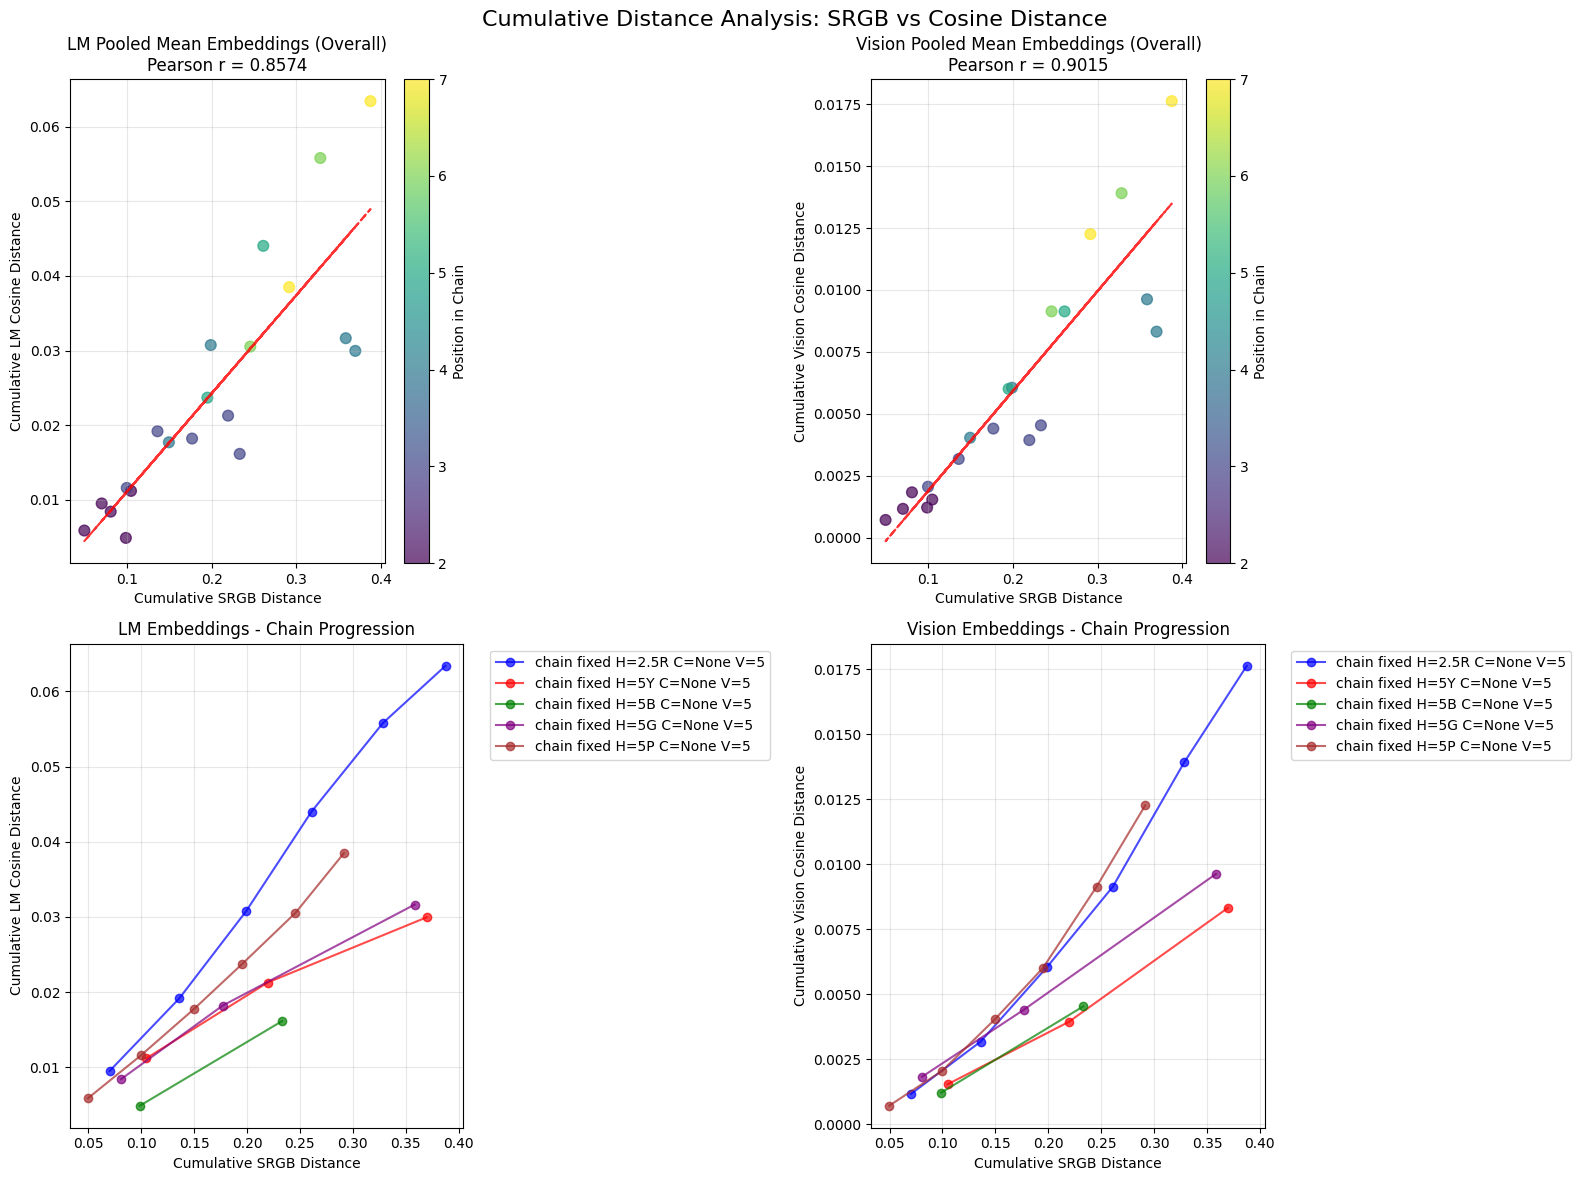

In [76]:
# Create visualizations for cumulative distance analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cumulative Distance Analysis: SRGB vs Cosine Distance', fontsize=16)

# Plot 1: Overall LM Pooled Mean - Scatter plot
axes[0, 0].scatter(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_lm_cosine_distance'], 
                   alpha=0.7, s=60, c=cumulative_df['position_in_chain'], cmap='viridis')
axes[0, 0].set_xlabel('Cumulative SRGB Distance')
axes[0, 0].set_ylabel('Cumulative LM Cosine Distance')
axes[0, 0].set_title(f'LM Pooled Mean Embeddings (Overall)\nPearson r = {cumulative_correlations["overall_lm_pearson"][0]:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_lm_cosine_distance'], 1)
p = np.poly1d(z)
axes[0, 0].plot(cumulative_df['cumulative_srgb_distance'], p(cumulative_df['cumulative_srgb_distance']), "r--", alpha=0.8)

# Add colorbar for position
cbar = plt.colorbar(axes[0, 0].collections[0], ax=axes[0, 0])
cbar.set_label('Position in Chain')

# Plot 2: Overall Vision Pooled Mean - Scatter plot
axes[0, 1].scatter(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_vision_cosine_distance'], 
                   alpha=0.7, s=60, c=cumulative_df['position_in_chain'], cmap='viridis')
axes[0, 1].set_xlabel('Cumulative SRGB Distance')
axes[0, 1].set_ylabel('Cumulative Vision Cosine Distance')
axes[0, 1].set_title(f'Vision Pooled Mean Embeddings (Overall)\nPearson r = {cumulative_correlations["overall_vision_pearson"][0]:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_vision_cosine_distance'], 1)
p = np.poly1d(z)
axes[0, 1].plot(cumulative_df['cumulative_srgb_distance'], p(cumulative_df['cumulative_srgb_distance']), "r--", alpha=0.8)

# Add colorbar for position
cbar = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])
cbar.set_label('Position in Chain')

# Plot 3: Chain-wise progression - LM embeddings
chain_colors = ['blue', 'red', 'green', 'purple', 'brown', 'orange', 'pink']
for i, chain_desc in enumerate(cumulative_df['chain_description'].unique()):
    chain_data = cumulative_df[cumulative_df['chain_description'] == chain_desc]
    if len(chain_data) > 0:
        axes[1, 0].plot(chain_data['cumulative_srgb_distance'], chain_data['cumulative_lm_cosine_distance'], 
                       'o-', label=chain_desc, alpha=0.7, color=chain_colors[i % len(chain_colors)], markersize=6)

axes[1, 0].set_xlabel('Cumulative SRGB Distance')
axes[1, 0].set_ylabel('Cumulative LM Cosine Distance')
axes[1, 0].set_title('LM Embeddings - Chain Progression')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Chain-wise progression - Vision embeddings
for i, chain_desc in enumerate(cumulative_df['chain_description'].unique()):
    chain_data = cumulative_df[cumulative_df['chain_description'] == chain_desc]
    if len(chain_data) > 0:
        axes[1, 1].plot(chain_data['cumulative_srgb_distance'], chain_data['cumulative_vision_cosine_distance'], 
                       'o-', label=chain_desc, alpha=0.7, color=chain_colors[i % len(chain_colors)], markersize=6)

axes[1, 1].set_xlabel('Cumulative SRGB Distance')
axes[1, 1].set_ylabel('Cumulative Vision Cosine Distance')
axes[1, 1].set_title('Vision Embeddings - Chain Progression')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [77]:
# Calculate cumulative distances from first color in each chain
def calculate_cumulative_distances():
    """Calculate cumulative SRGB and cosine distances from the first color in each chain"""
    cumulative_data = []
    
    for chain in dataset_manifest['chains']:
        chain_items = chain['items']
        chain_description = chain['description']
        
        if len(chain_items) <= 2:
            continue
            
        # Get the first color as reference
        first_idx = str(chain_items[0]['index'])
        first_srgb = srgb_colors[first_idx]
        
        # Get embeddings for the first color
        first_emb_idx = np.where(np.array([int(idx) for idx in embeddings_data['indices']]) == int(first_idx))[0]
        if len(first_emb_idx) == 0:
            continue
            
        first_lm_emb = np.array([emb for emb in embeddings_data['lm_pooled_mean'] if emb is not None])[first_emb_idx[0]]
        first_vision_emb = np.array([emb for emb in embeddings_data['vision_pooled_mean'] if emb is not None])[first_emb_idx[0]]
        
        # Calculate cumulative distances for each subsequent color
        for i in range(1, len(chain_items)):
            current_idx = str(chain_items[i]['index'])
            current_srgb = srgb_colors[current_idx]
            
            # Get embeddings for current color
            current_emb_idx = np.where(np.array([int(idx) for idx in embeddings_data['indices']]) == int(current_idx))[0]
            if len(current_emb_idx) == 0:
                continue
                
            current_lm_emb = np.array([emb for emb in embeddings_data['lm_pooled_mean'] if emb is not None])[current_emb_idx[0]]
            current_vision_emb = np.array([emb for emb in embeddings_data['vision_pooled_mean'] if emb is not None])[current_emb_idx[0]]
            
            # Calculate cumulative SRGB distance
            cumulative_srgb_dist = np.linalg.norm(current_srgb - first_srgb)
            
            # Calculate cumulative cosine distances
            cumulative_lm_cosine_dist = cosine(first_lm_emb, current_lm_emb)
            cumulative_vision_cosine_dist = cosine(first_vision_emb, current_vision_emb)
            
            cumulative_data.append({
                'chain_description': chain_description,
                'first_color': chain_items[1]['notation'],
                'current_color': chain_items[i]['notation'],
                'position_in_chain': i,
                'cumulative_srgb_distance': cumulative_srgb_dist,
                'cumulative_lm_cosine_distance': cumulative_lm_cosine_dist,
                'cumulative_vision_cosine_distance': cumulative_vision_cosine_dist
            })
    
    return cumulative_data

cumulative_data = calculate_cumulative_distances()
cumulative_df = pd.DataFrame(cumulative_data)

print(f"Calculated cumulative distances for {len(cumulative_data)} color positions")
print("\nSample cumulative distances:")
for i, row in cumulative_df.head(5).iterrows():
    print(f"  {row['first_color']} → {row['current_color']} (pos {row['position_in_chain']}): "
          f"SRGB={row['cumulative_srgb_distance']:.4f}, LM_cos={row['cumulative_lm_cosine_distance']:.4f}, "
          f"Vision_cos={row['cumulative_vision_cosine_distance']:.4f}")

print(f"\nChain breakdown:")
for chain_desc in cumulative_df['chain_description'].unique():
    chain_data = cumulative_df[cumulative_df['chain_description'] == chain_desc]
    print(f"  {chain_desc}: {len(chain_data)} positions")


Calculated cumulative distances for 25 color positions

Sample cumulative distances:
  2.5R 5/2 → 2.5R 5/2 (pos 1): SRGB=0.0668, LM_cos=0.0246, Vision_cos=0.0037
  2.5R 5/2 → 2.5R 5/4 (pos 2): SRGB=0.1368, LM_cos=0.0547, Vision_cos=0.0072
  2.5R 5/2 → 2.5R 5/6 (pos 3): SRGB=0.2025, LM_cos=0.0660, Vision_cos=0.0095
  2.5R 5/2 → 2.5R 5/8 (pos 4): SRGB=0.2652, LM_cos=0.0749, Vision_cos=0.0120
  2.5R 5/2 → 2.5R 5/10 (pos 5): SRGB=0.3269, LM_cos=0.0843, Vision_cos=0.0147

Chain breakdown:
  chain fixed H=2.5R C=None V=5: 7 positions
  chain fixed H=5Y C=None V=5: 4 positions
  chain fixed H=5B C=None V=5: 3 positions
  chain fixed H=5G C=None V=5: 4 positions
  chain fixed H=5P C=None V=5: 7 positions


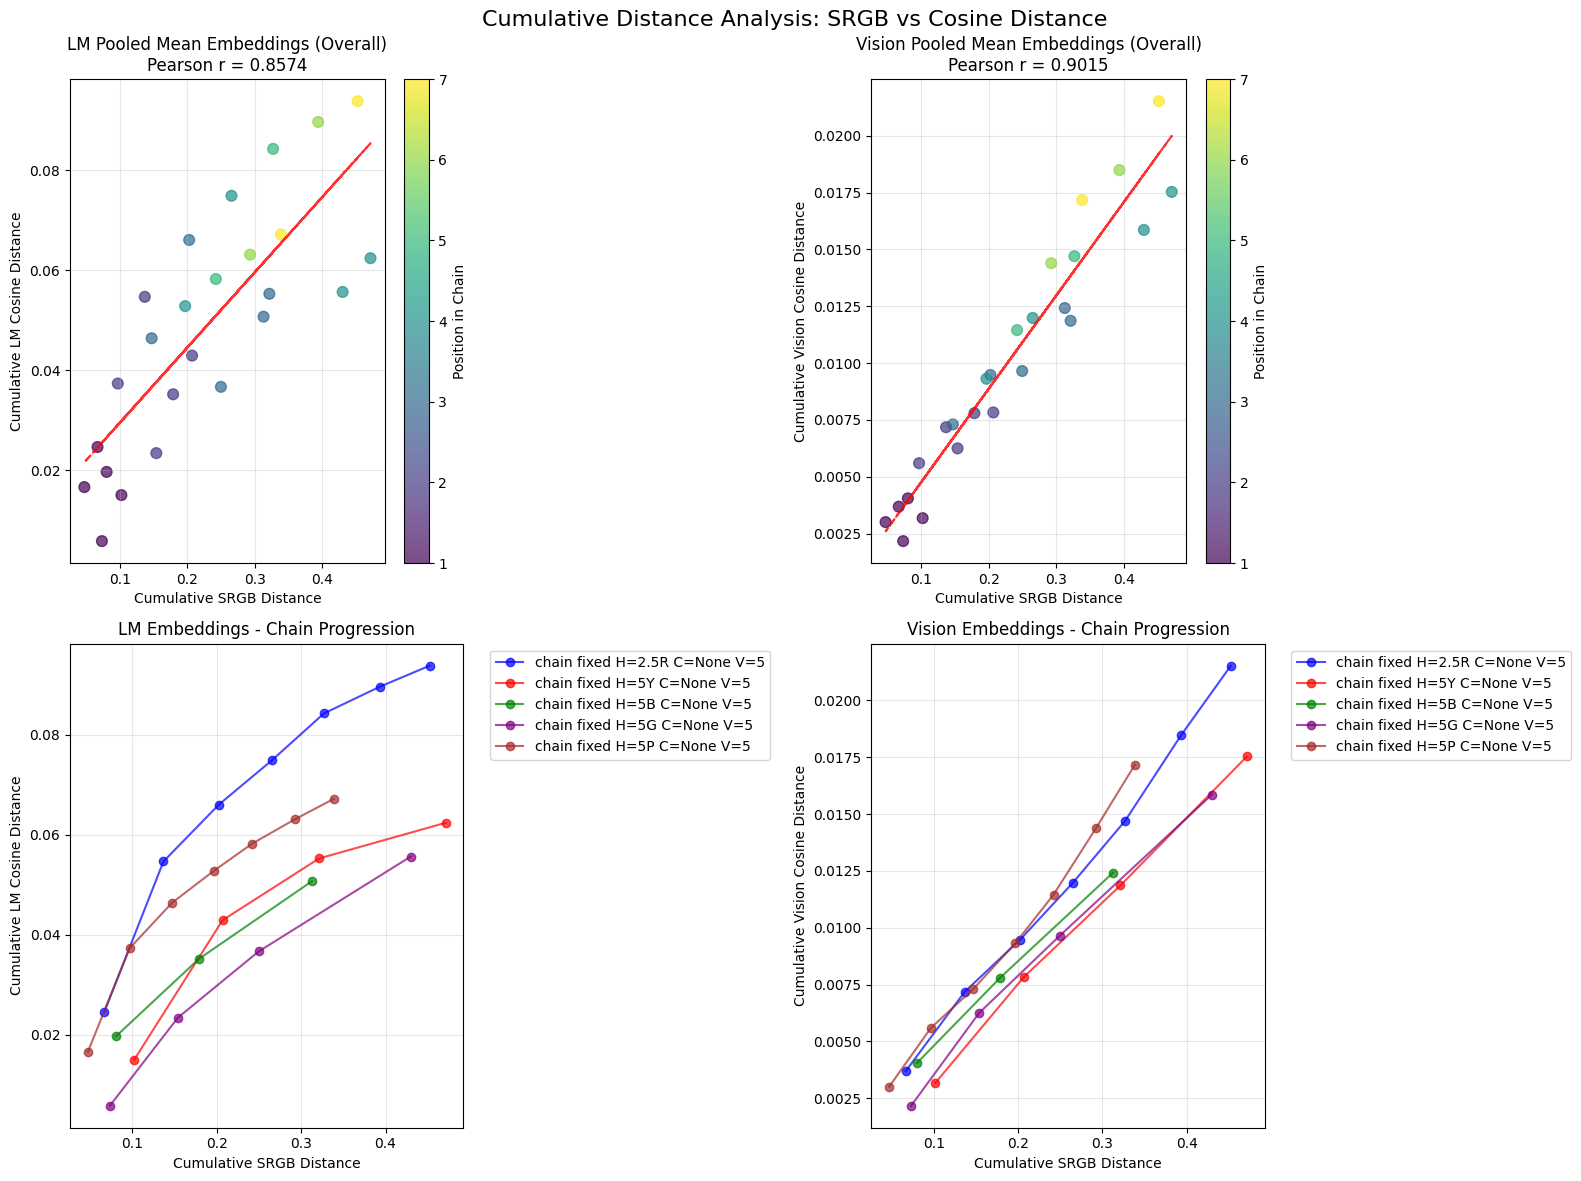

In [78]:
# Create visualizations for cumulative distance analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cumulative Distance Analysis: SRGB vs Cosine Distance', fontsize=16)

# Plot 1: Overall LM Pooled Mean - Scatter plot
axes[0, 0].scatter(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_lm_cosine_distance'], 
                   alpha=0.7, s=60, c=cumulative_df['position_in_chain'], cmap='viridis')
axes[0, 0].set_xlabel('Cumulative SRGB Distance')
axes[0, 0].set_ylabel('Cumulative LM Cosine Distance')
axes[0, 0].set_title(f'LM Pooled Mean Embeddings (Overall)\nPearson r = {cumulative_correlations["overall_lm_pearson"][0]:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_lm_cosine_distance'], 1)
p = np.poly1d(z)
axes[0, 0].plot(cumulative_df['cumulative_srgb_distance'], p(cumulative_df['cumulative_srgb_distance']), "r--", alpha=0.8)

# Add colorbar for position
cbar = plt.colorbar(axes[0, 0].collections[0], ax=axes[0, 0])
cbar.set_label('Position in Chain')

# Plot 2: Overall Vision Pooled Mean - Scatter plot
axes[0, 1].scatter(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_vision_cosine_distance'], 
                   alpha=0.7, s=60, c=cumulative_df['position_in_chain'], cmap='viridis')
axes[0, 1].set_xlabel('Cumulative SRGB Distance')
axes[0, 1].set_ylabel('Cumulative Vision Cosine Distance')
axes[0, 1].set_title(f'Vision Pooled Mean Embeddings (Overall)\nPearson r = {cumulative_correlations["overall_vision_pearson"][0]:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_vision_cosine_distance'], 1)
p = np.poly1d(z)
axes[0, 1].plot(cumulative_df['cumulative_srgb_distance'], p(cumulative_df['cumulative_srgb_distance']), "r--", alpha=0.8)

# Add colorbar for position
cbar = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])
cbar.set_label('Position in Chain')

# Plot 3: Chain-wise progression - LM embeddings
chain_colors = ['blue', 'red', 'green', 'purple', 'brown', 'orange', 'pink']
for i, chain_desc in enumerate(cumulative_df['chain_description'].unique()):
    chain_data = cumulative_df[cumulative_df['chain_description'] == chain_desc]
    if len(chain_data) > 0:
        axes[1, 0].plot(chain_data['cumulative_srgb_distance'], chain_data['cumulative_lm_cosine_distance'], 
                       'o-', label=chain_desc, alpha=0.7, color=chain_colors[i % len(chain_colors)], markersize=6)

axes[1, 0].set_xlabel('Cumulative SRGB Distance')
axes[1, 0].set_ylabel('Cumulative LM Cosine Distance')
axes[1, 0].set_title('LM Embeddings - Chain Progression')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Chain-wise progression - Vision embeddings
for i, chain_desc in enumerate(cumulative_df['chain_description'].unique()):
    chain_data = cumulative_df[cumulative_df['chain_description'] == chain_desc]
    if len(chain_data) > 0:
        axes[1, 1].plot(chain_data['cumulative_srgb_distance'], chain_data['cumulative_vision_cosine_distance'], 
                       'o-', label=chain_desc, alpha=0.7, color=chain_colors[i % len(chain_colors)], markersize=6)

axes[1, 1].set_xlabel('Cumulative SRGB Distance')
axes[1, 1].set_ylabel('Cumulative Vision Cosine Distance')
axes[1, 1].set_title('Vision Embeddings - Chain Progression')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [34]:
# Compute cumulative Munsell C distances per chain position

def compute_cumulative_chroma_distances():
    """Compute cumulative distance in Munsell chroma (C) from the first color in each chain.
    Provides two measures:
    - c_direct_abs_from_first: |C_i - C_0|
    - c_path_length_sum_abs: sum_{k=1..i} |C_k - C_{k-1}| (handles non-monotonic chains)
    """
    records = []
    
    for chain in dataset_manifest['chains']:
        items = chain['items']
        if len(items) < 2:
            continue
        
        # Extract C values for the chain
        C_values = [it.get('C') for it in items]
        # Skip if first C is missing
        if C_values[0] is None:
            continue
        
        # Convert to floats where possible
        C_values_float = [float(c) if c is not None else None for c in C_values]
        C0 = C_values_float[0]
        path_cum = 0.0
        
        for i in range(1, len(items)):
            Ci = C_values_float[i]
            Cprev = C_values_float[i-1]
            if Ci is None or Cprev is None:
                continue
            step = abs(Ci - Cprev)
            path_cum += step
            
            records.append({
                'chain_description': chain['description'],
                'first_color': items[0]['notation'],
                'current_color': items[i]['notation'],
                'position_in_chain': i,
                'c_direct_abs_from_first': abs(Ci - C0),
                'c_path_length_sum_abs': path_cum
            })
    
    return pd.DataFrame(records)

cumulative_C_df = compute_cumulative_chroma_distances()
print(f"Computed cumulative C distances for {len(cumulative_C_df)} positions")
print(cumulative_C_df.head())


Computed cumulative C distances for 26 positions
               chain_description first_color current_color  position_in_chain  \
0     chain fixed H=N C=0 V=None          N0            N1                  1   
1  chain fixed H=2.5R C=None V=5    2.5R 5/0      2.5R 5/2                  1   
2  chain fixed H=2.5R C=None V=5    2.5R 5/0      2.5R 5/4                  2   
3  chain fixed H=2.5R C=None V=5    2.5R 5/0      2.5R 5/6                  3   
4  chain fixed H=2.5R C=None V=5    2.5R 5/0      2.5R 5/8                  4   

   c_direct_abs_from_first  c_path_length_sum_abs  
0                      0.0                    0.0  
1                      2.0                    2.0  
2                      4.0                    4.0  
3                      6.0                    6.0  
4                      8.0                    8.0  


In [35]:
# Merge cumulative C distances with cumulative cosine distances (by chain, position)

# Prepare keys for merge
cumulative_df_keyed = cumulative_df.copy()
cumulative_df_keyed['key'] = list(zip(cumulative_df_keyed['chain_description'], cumulative_df_keyed['position_in_chain']))

cumulative_C_df_keyed = cumulative_C_df.copy()
cumulative_C_df_keyed['key'] = list(zip(cumulative_C_df_keyed['chain_description'], cumulative_C_df_keyed['position_in_chain']))

merged_cumulative = pd.merge(cumulative_df_keyed, cumulative_C_df_keyed[['key','c_direct_abs_from_first','c_path_length_sum_abs']], on='key', how='inner')
print(f"Merged rows: {len(merged_cumulative)}")


Merged rows: 25


In [36]:
# Correlations: cumulative C vs cumulative cosine distances
from scipy.stats import pearsonr, spearmanr

# Overall
lm_r_p = pearsonr(merged_cumulative['c_path_length_sum_abs'], merged_cumulative['cumulative_lm_cosine_distance'])
lm_rho_p = spearmanr(merged_cumulative['c_path_length_sum_abs'], merged_cumulative['cumulative_lm_cosine_distance'])
vision_r_p = pearsonr(merged_cumulative['c_path_length_sum_abs'], merged_cumulative['cumulative_vision_cosine_distance'])
vision_rho_p = spearmanr(merged_cumulative['c_path_length_sum_abs'], merged_cumulative['cumulative_vision_cosine_distance'])

print("CUMULATIVE C vs COSINE DISTANCE CORRELATIONS")
print("=" * 60)
print("Using path-length cumulative C (sum of |ΔC|)")
print(f"LM: Pearson r={lm_r_p[0]:.4f} (p={lm_r_p[1]:.4e}), Spearman ρ={lm_rho_p.correlation:.4f} (p={lm_rho_p.pvalue:.4e})")
print(f"Vision: Pearson r={vision_r_p[0]:.4f} (p={vision_r_p[1]:.4e}), Spearman ρ={vision_rho_p.correlation:.4f} (p={vision_rho_p.pvalue:.4e})")

# Also report direct distance from first
lm_r_p_direct = pearsonr(merged_cumulative['c_direct_abs_from_first'], merged_cumulative['cumulative_lm_cosine_distance'])
lm_rho_p_direct = spearmanr(merged_cumulative['c_direct_abs_from_first'], merged_cumulative['cumulative_lm_cosine_distance'])
vision_r_p_direct = pearsonr(merged_cumulative['c_direct_abs_from_first'], merged_cumulative['cumulative_vision_cosine_distance'])
vision_rho_p_direct = spearmanr(merged_cumulative['c_direct_abs_from_first'], merged_cumulative['cumulative_vision_cosine_distance'])

print("\nUsing direct |C_i - C_0|:")
print(f"LM: Pearson r={lm_r_p_direct[0]:.4f} (p={lm_r_p_direct[1]:.4e}), Spearman ρ={lm_rho_p_direct.correlation:.4f} (p={lm_rho_p_direct.pvalue:.4e})")
print(f"Vision: Pearson r={vision_r_p_direct[0]:.4f} (p={vision_r_p_direct[1]:.4e}), Spearman ρ={vision_rho_p_direct.correlation:.4f} (p={vision_rho_p_direct.pvalue:.4e})")

# Chain-wise correlations
print("\nChain-wise correlations (path-length C):")
for chain_desc in merged_cumulative['chain_description'].unique():
    sub = merged_cumulative[merged_cumulative['chain_description'] == chain_desc]
    if len(sub) > 1:
        r, p = pearsonr(sub['c_path_length_sum_abs'], sub['cumulative_lm_cosine_distance'])
        rv, pv = pearsonr(sub['c_path_length_sum_abs'], sub['cumulative_vision_cosine_distance'])
        print(f"  {chain_desc}: LM r={r:.4f} (p={p:.2e}), Vision r={rv:.4f} (p={pv:.2e}), n={len(sub)}")


CUMULATIVE C vs COSINE DISTANCE CORRELATIONS
Using path-length cumulative C (sum of |ΔC|)
LM: Pearson r=0.8691 (p=1.7369e-08), Spearman ρ=0.9074 (p=3.9235e-10)
Vision: Pearson r=0.9155 (p=1.4428e-10), Spearman ρ=0.9207 (p=7.0795e-11)

Using direct |C_i - C_0|:
LM: Pearson r=0.8691 (p=1.7369e-08), Spearman ρ=0.9074 (p=3.9235e-10)
Vision: Pearson r=0.9155 (p=1.4428e-10), Spearman ρ=0.9207 (p=7.0795e-11)

Chain-wise correlations (path-length C):
  chain fixed H=2.5R C=None V=5: LM r=0.9462 (p=1.25e-03), Vision r=0.9976 (p=5.18e-07), n=7
  chain fixed H=5Y C=None V=5: LM r=0.9557 (p=4.43e-02), Vision r=0.9977 (p=2.32e-03), n=4
  chain fixed H=5B C=None V=5: LM r=1.0000 (p=4.23e-05), Vision r=0.9982 (p=3.85e-02), n=3
  chain fixed H=5G C=None V=5: LM r=0.9979 (p=2.09e-03), Vision r=0.9913 (p=8.66e-03), n=4
  chain fixed H=5P C=None V=5: LM r=0.9525 (p=9.19e-04), Vision r=0.9964 (p=1.49e-06), n=7


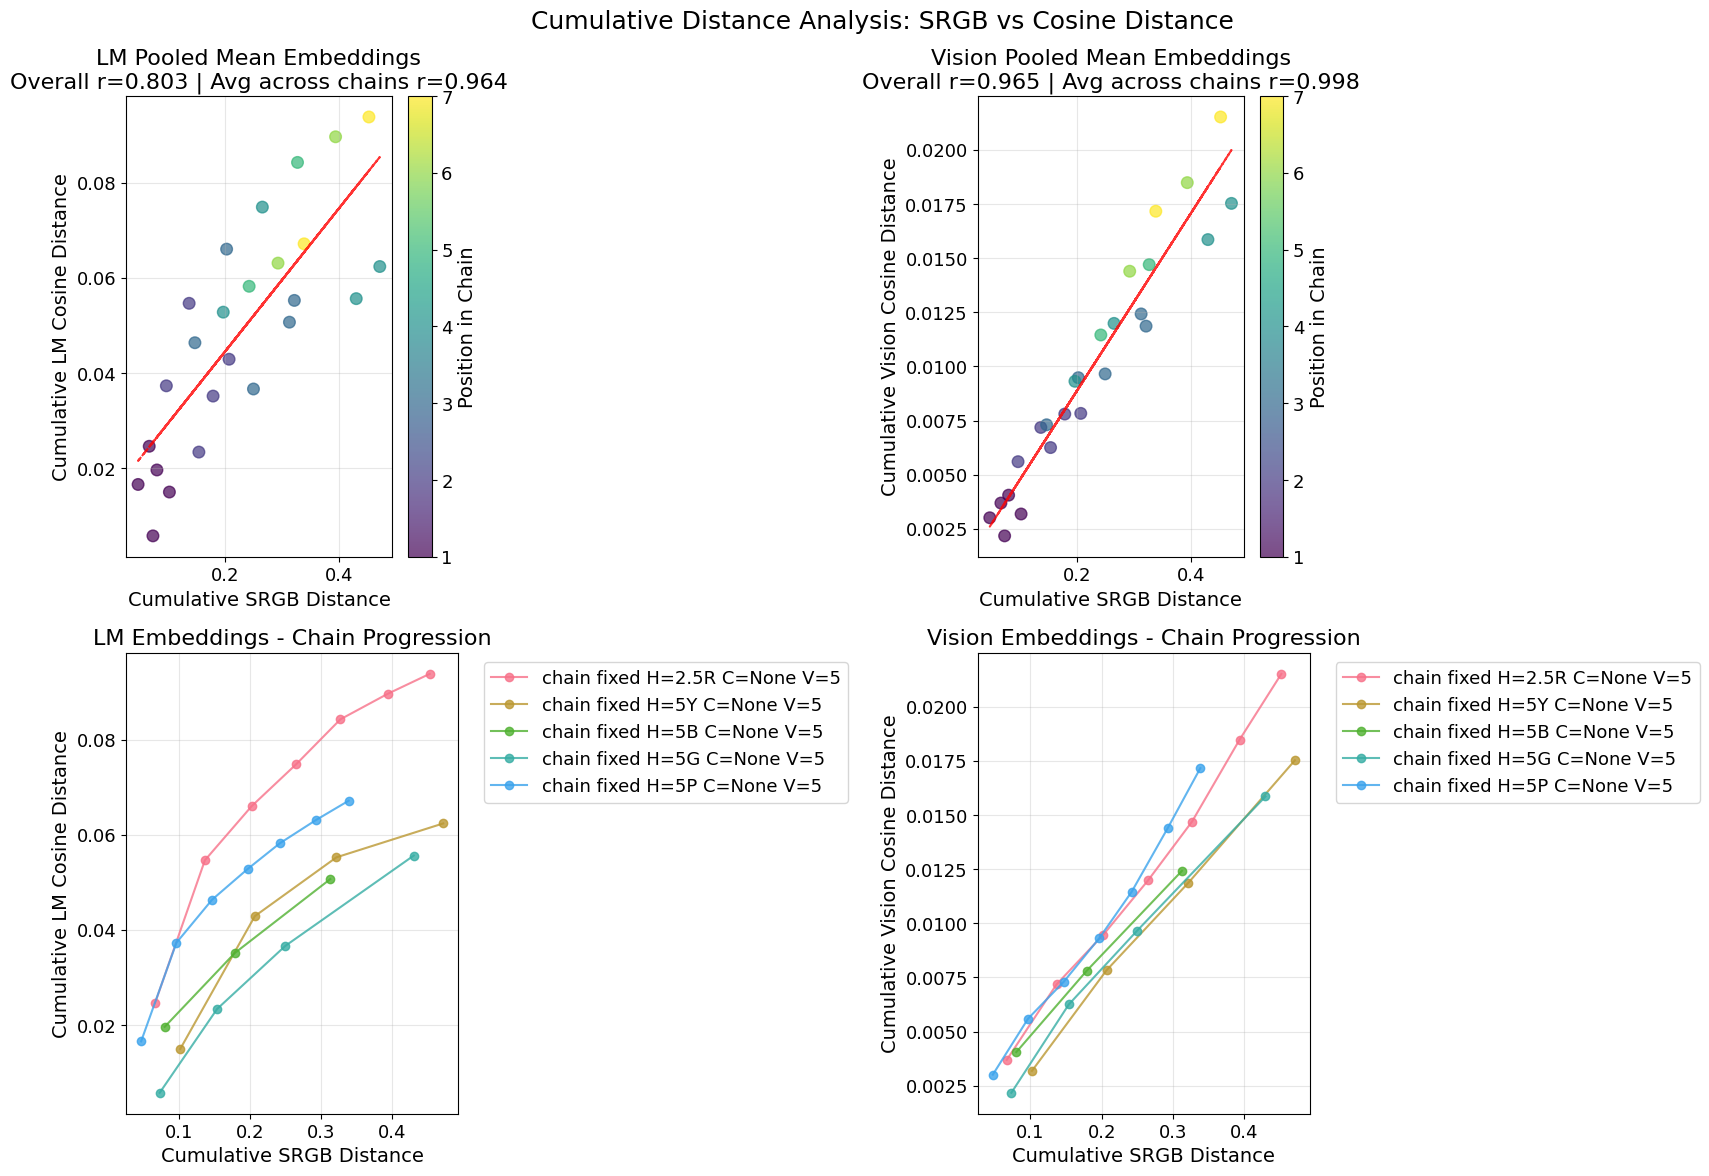

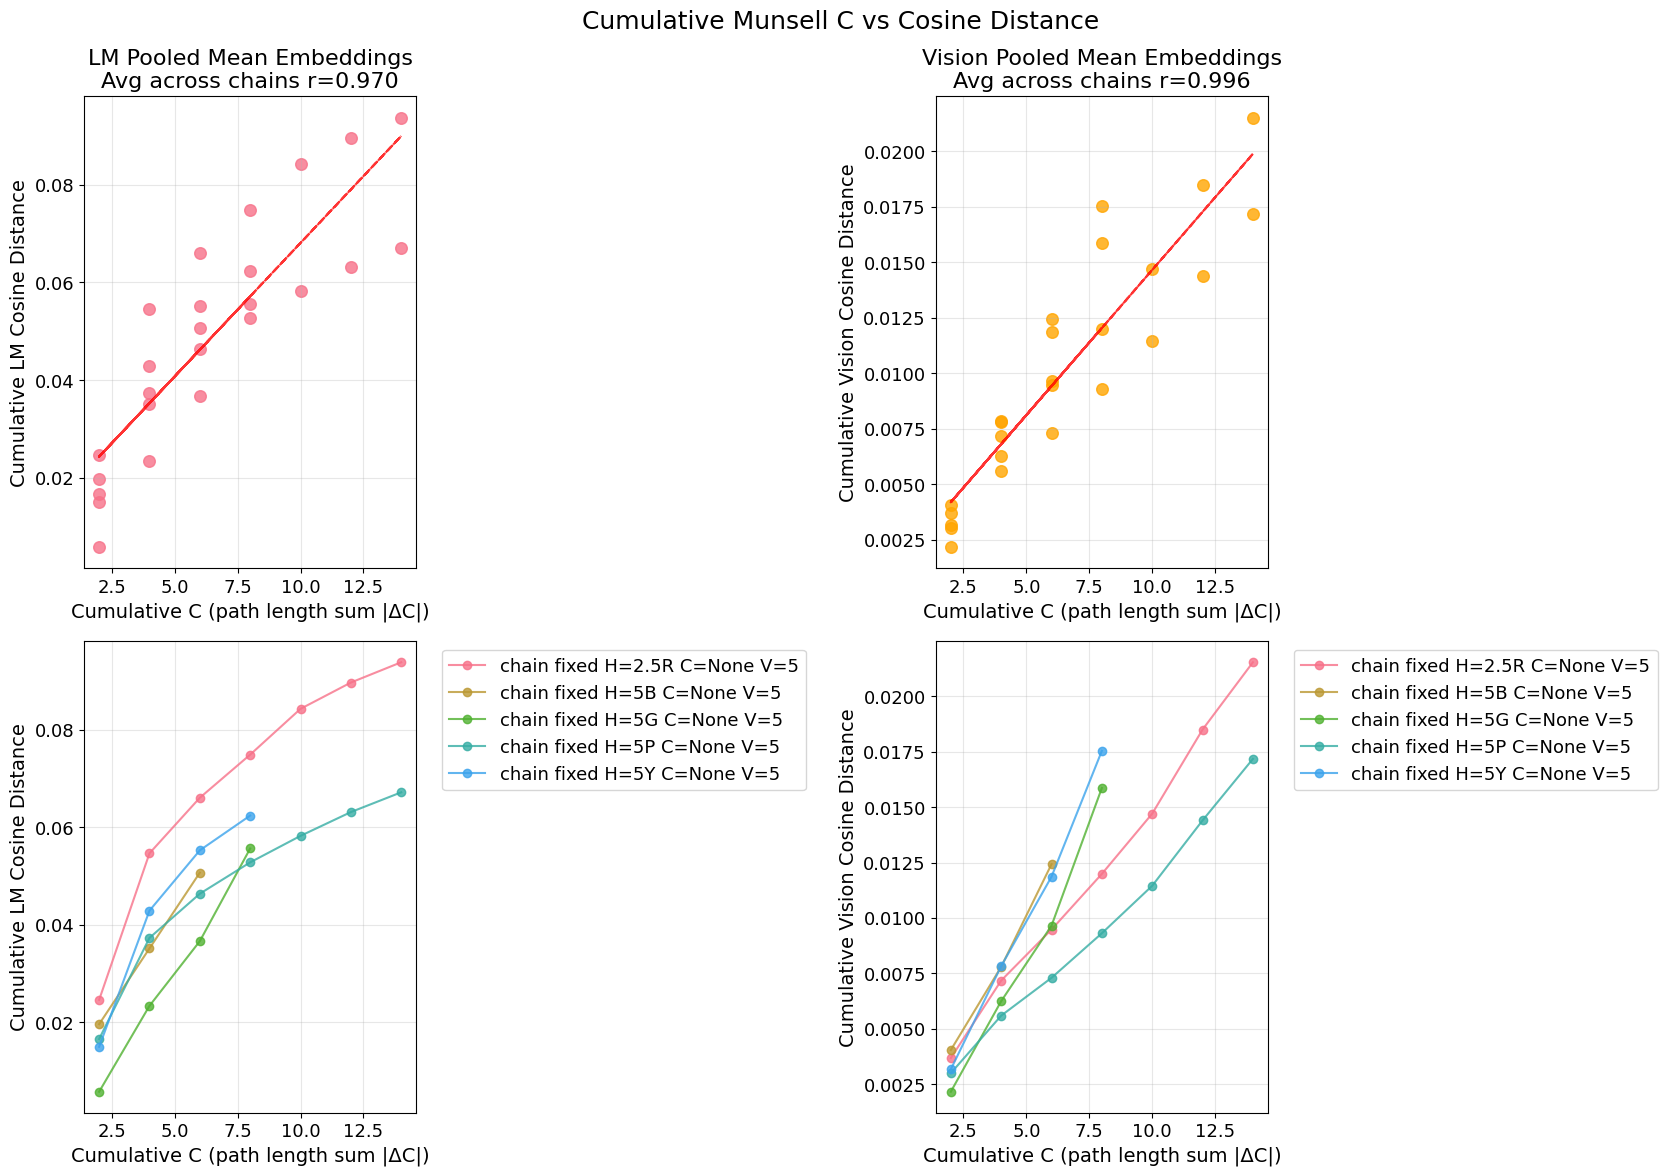

In [37]:
# Helper to compute average Pearson r across chains and format annotation

def average_chain_pearson(df, x_col, y_col, group_col='chain_description'):
    vals = []
    for chain_desc, sub in df.groupby(group_col):
        if len(sub) > 1:
            r, p = pearsonr(sub[x_col], sub[y_col])
            vals.append(r)
    return np.mean(vals) if vals else np.nan

# Global font size adjustments
base_fs = 13
plt.rcParams['font.size'] = base_fs
plt.rcParams['axes.titlesize'] = base_fs + 3
plt.rcParams['axes.labelsize'] = base_fs + 1
plt.rcParams['xtick.labelsize'] = base_fs
plt.rcParams['ytick.labelsize'] = base_fs
plt.rcParams['legend.fontsize'] = base_fs

# Redraw cumulative SRGB vs cosine plots with average r annotation and bigger text
fig, axes = plt.subplots(2, 2, figsize=(17, 12))
fig.suptitle('Cumulative Distance Analysis: SRGB vs Cosine Distance', fontsize=base_fs + 5)

# Compute average r across chains
avg_r_lm = average_chain_pearson(cumulative_df, 'cumulative_srgb_distance', 'cumulative_lm_cosine_distance')
avg_r_vis = average_chain_pearson(cumulative_df, 'cumulative_srgb_distance', 'cumulative_vision_cosine_distance')

# Plot 1: Overall LM Pooled Mean - Scatter plot
axes[0, 0].scatter(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_lm_cosine_distance'], 
                   alpha=0.7, s=70, c=cumulative_df['position_in_chain'], cmap='viridis')
axes[0, 0].set_xlabel('Cumulative SRGB Distance')
axes[0, 0].set_ylabel('Cumulative LM Cosine Distance')
axes[0, 0].set_title(f'LM Pooled Mean Embeddings\nOverall r={cumulative_correlations["overall_lm_pearson"][0]:.3f} | Avg across chains r={avg_r_lm:.3f}')
axes[0, 0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_lm_cosine_distance'], 1)
p = np.poly1d(z)
axes[0, 0].plot(cumulative_df['cumulative_srgb_distance'], p(cumulative_df['cumulative_srgb_distance']), "r--", alpha=0.8)

# Add colorbar for position
cbar = plt.colorbar(axes[0, 0].collections[0], ax=axes[0, 0])
cbar.set_label('Position in Chain')

# Plot 2: Overall Vision Pooled Mean - Scatter plot
axes[0, 1].scatter(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_vision_cosine_distance'], 
                   alpha=0.7, s=70, c=cumulative_df['position_in_chain'], cmap='viridis')
axes[0, 1].set_xlabel('Cumulative SRGB Distance')
axes[0, 1].set_ylabel('Cumulative Vision Cosine Distance')
axes[0, 1].set_title(f'Vision Pooled Mean Embeddings\nOverall r={cumulative_correlations["overall_vision_pearson"][0]:.3f} | Avg across chains r={avg_r_vis:.3f}')
axes[0, 1].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(cumulative_df['cumulative_srgb_distance'], cumulative_df['cumulative_vision_cosine_distance'], 1)
p = np.poly1d(z)
axes[0, 1].plot(cumulative_df['cumulative_srgb_distance'], p(cumulative_df['cumulative_srgb_distance']), "r--", alpha=0.8)

# Add colorbar for position
cbar = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])
cbar.set_label('Position in Chain')

# Plot 3: Chain-wise progression - LM embeddings
for i, chain_desc in enumerate(cumulative_df['chain_description'].unique()):
    chain_data = cumulative_df[cumulative_df['chain_description'] == chain_desc]
    if len(chain_data) > 0:
        axes[1, 0].plot(chain_data['cumulative_srgb_distance'], chain_data['cumulative_lm_cosine_distance'], 
                       'o-', label=chain_desc, alpha=0.8, markersize=6)

axes[1, 0].set_xlabel('Cumulative SRGB Distance')
axes[1, 0].set_ylabel('Cumulative LM Cosine Distance')
axes[1, 0].set_title('LM Embeddings - Chain Progression')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Chain-wise progression - Vision embeddings
for i, chain_desc in enumerate(cumulative_df['chain_description'].unique()):
    chain_data = cumulative_df[cumulative_df['chain_description'] == chain_desc]
    if len(chain_data) > 0:
        axes[1, 1].plot(chain_data['cumulative_srgb_distance'], chain_data['cumulative_vision_cosine_distance'], 
                       'o-', label=chain_desc, alpha=0.8, markersize=6)

axes[1, 1].set_xlabel('Cumulative SRGB Distance')
axes[1, 1].set_ylabel('Cumulative Vision Cosine Distance')
axes[1, 1].set_title('Vision Embeddings - Chain Progression')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Redraw cumulative C vs cosine plots with average r annotation and bigger text
fig, axes = plt.subplots(2, 2, figsize=(17, 12))
fig.suptitle('Cumulative Munsell C vs Cosine Distance', fontsize=base_fs + 5)

avg_r_lm_c = average_chain_pearson(merged_cumulative, 'c_path_length_sum_abs', 'cumulative_lm_cosine_distance')
avg_r_vis_c = average_chain_pearson(merged_cumulative, 'c_path_length_sum_abs', 'cumulative_vision_cosine_distance')

# Plot 1: Overall LM (C)
axes[0, 0].scatter(merged_cumulative['c_path_length_sum_abs'], merged_cumulative['cumulative_lm_cosine_distance'],
                   alpha=0.8, s=70)
axes[0, 0].set_xlabel('Cumulative C (path length sum |ΔC|)')
axes[0, 0].set_ylabel('Cumulative LM Cosine Distance')
axes[0, 0].set_title(f'LM Pooled Mean Embeddings\nAvg across chains r={avg_r_lm_c:.3f}')
axes[0, 0].grid(True, alpha=0.3)

z = np.polyfit(merged_cumulative['c_path_length_sum_abs'], merged_cumulative['cumulative_lm_cosine_distance'], 1)
p = np.poly1d(z)
axes[0, 0].plot(merged_cumulative['c_path_length_sum_abs'], p(merged_cumulative['c_path_length_sum_abs']), 'r--', alpha=0.8)

# Plot 2: Overall Vision (C)
axes[0, 1].scatter(merged_cumulative['c_path_length_sum_abs'], merged_cumulative['cumulative_vision_cosine_distance'],
                   alpha=0.8, s=70, color='orange')
axes[0, 1].set_xlabel('Cumulative C (path length sum |ΔC|)')
axes[0, 1].set_ylabel('Cumulative Vision Cosine Distance')
axes[0, 1].set_title(f'Vision Pooled Mean Embeddings\nAvg across chains r={avg_r_vis_c:.3f}')
axes[0, 1].grid(True, alpha=0.3)

z = np.polyfit(merged_cumulative['c_path_length_sum_abs'], merged_cumulative['cumulative_vision_cosine_distance'], 1)
p = np.poly1d(z)
axes[0, 1].plot(merged_cumulative['c_path_length_sum_abs'], p(merged_cumulative['c_path_length_sum_abs']), 'r--', alpha=0.8)

# Plot 3: Chain-wise LM progression (C)
for chain_desc, sub in merged_cumulative.groupby('chain_description'):
    axes[1, 0].plot(sub['c_path_length_sum_abs'], sub['cumulative_lm_cosine_distance'], 'o-', label=chain_desc, alpha=0.8)
axes[1, 0].set_xlabel('Cumulative C (path length sum |ΔC|)')
axes[1, 0].set_ylabel('Cumulative LM Cosine Distance')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Chain-wise Vision progression (C)
for chain_desc, sub in merged_cumulative.groupby('chain_description'):
    axes[1, 1].plot(sub['c_path_length_sum_abs'], sub['cumulative_vision_cosine_distance'], 'o-', label=chain_desc, alpha=0.8)
axes[1, 1].set_xlabel('Cumulative C (path length sum |ΔC|)')
axes[1, 1].set_ylabel('Cumulative Vision Cosine Distance')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Let's see the correlation between actual hex code of color and the color that the model names.

In [38]:
from pathlib import Path
import json, re
import pandas as pd
import numpy as np

In [39]:
embeddings_dir = Path("data/embeddings/qwen2.5_7B/hex_code")
dataset_manifest_path = Path("data/colors/munsell_colors/munsell_manifest.csv")

In [40]:
munsell_df = pd.read_csv(dataset_manifest_path)

In [41]:
munsell_df['HEX'] = '#' + (munsell_df[['R','G','B']].mul(255).round().astype(int).clip(0,255)
                   .apply(lambda s: '{:02X}{:02X}{:02X}'.format(*s), axis=1))

In [42]:
HEX_RE = re.compile(r'#([0-9A-Fa-f]{6})')

def extract_hex(text: str) -> str | None:
    m = HEX_RE.search(text or '')
    return f"#{m.group(1).upper()}" if m else None

def build_hex_df(embeddings_dir: str) -> pd.DataFrame:
    rows = []
    for mf in Path(embeddings_dir).rglob('manifest.json'):
        try:
            data = json.loads(mf.read_text())
        except Exception:
            continue
        answer = data.get('answer', '') if isinstance(data, dict) else ''
        hex_code = extract_hex(answer)
        pic = mf.parent.name if mf.parent.name.isdigit() else data.get('image_id') or data.get('image_name')
        rows.append({'pic': pic, 'HEX': hex_code, 'manifest_path': str(mf)})
    df = pd.DataFrame(rows)
    df = df.dropna(subset=['HEX'])
    df['pic'] = pd.to_numeric(df['pic'], errors='ignore')
    return df

# example
df_hex = build_hex_df(embeddings_dir)
df_hex =df_hex.sort_values("pic")
df_hex.head()

,pic,HEX,manifest_path
774,1,#000000,data/embeddings/qwen2.5_7B/hex_code/1/manifest...
1697,2,#000000,data/embeddings/qwen2.5_7B/hex_code/2/manifest...
1615,3,#000000,data/embeddings/qwen2.5_7B/hex_code/3/manifest...
1601,4,#000000,data/embeddings/qwen2.5_7B/hex_code/4/manifest...
1709,5,#000000,data/embeddings/qwen2.5_7B/hex_code/5/manifest...


In [43]:
df_pred

NameError: name 'df_pred' is not defined

{'R': 0.8862549184145565, 'G': 0.83183163726778209, 'B': 0.79871059195067773, 'overall': 0.83362213215057257}


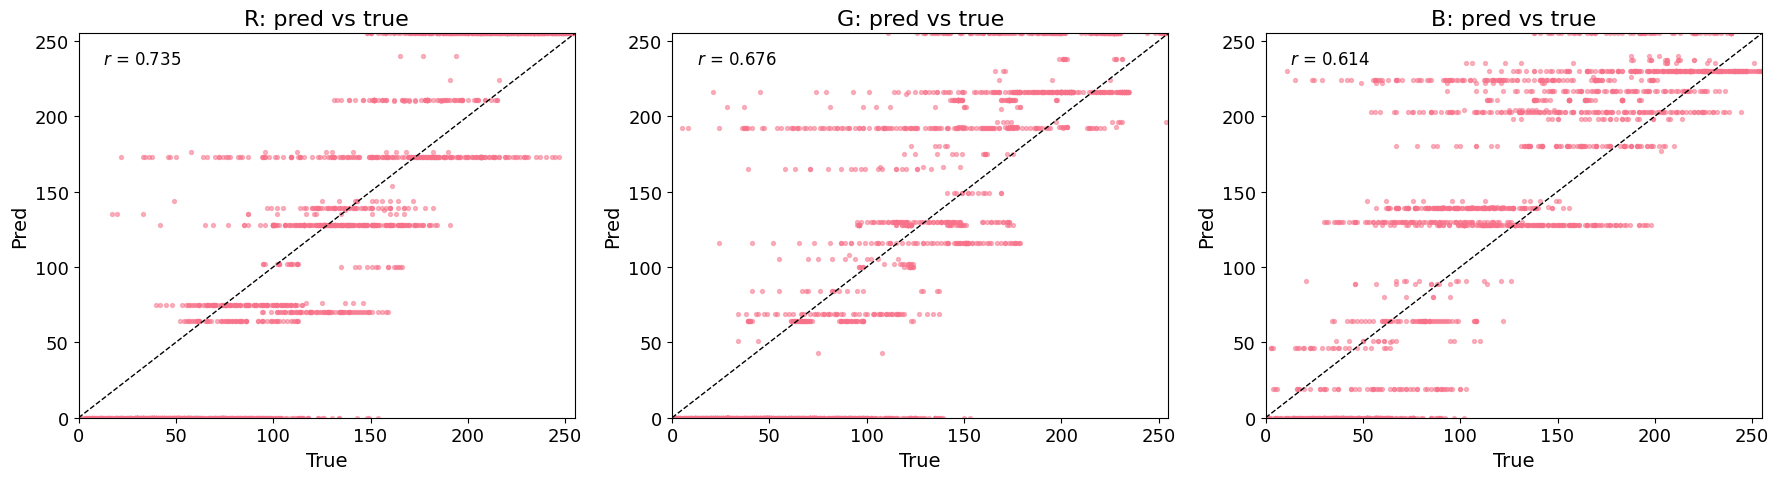

In [63]:
def hex_to_rgb_cols(s: pd.Series, prefix: str) -> pd.DataFrame:
    s = s.fillna('').astype(str).str.strip()
    s = s.str.extract(HEX_RE)[0].str.upper()  # keep 6 hex chars
    r = s.str[0:2].apply(lambda x: int(x,16) if isinstance(x,str) else np.nan)
    g = s.str[2:4].apply(lambda x: int(x,16) if isinstance(x,str) else np.nan)
    b = s.str[4:6].apply(lambda x: int(x,16) if isinstance(x,str) else np.nan)
    return pd.DataFrame({f'{prefix}R': r, f'{prefix}G': g, f'{prefix}B': b})

# df_true: columns ['pic','HEX_true']
# df_pred: columns ['pic','HEX_pred'] (rename if needed)
df_pred = df_hex.rename(columns={'HEX':'HEX_pred'})  # if your pred df used 'HEX'
df_true = munsell_df.rename(columns={"picture":"pic", "HEX":"HEX_true"})
# Ensure df_true['pic'] is integer, stripping '.png' if present
df_true['pic'] = df_true['pic'].astype(str).str.replace('.png','',regex=False)
df_true['pic'] = pd.to_numeric(df_true['pic'], errors='coerce')


df = pd.merge(df_true[['pic','HEX_true']], df_pred[['pic','HEX_pred']], on='pic', how='inner')
rgb_true = hex_to_rgb_cols(df['HEX_true'], 'T_')
rgb_pred = hex_to_rgb_cols(df['HEX_pred'], 'P_')
df_rgb = pd.concat([df[['pic']], rgb_true, rgb_pred], axis=1).dropna()

# Per-channel Pearson correlations
r_R = df_rgb[['T_R','P_R']].corr().iloc[0,1]
r_G = df_rgb[['T_G','P_G']].corr().iloc[0,1]
r_B = df_rgb[['T_B','P_B']].corr().iloc[0,1]

# Overall correlation across all channels (flattened vectors)
t_flat = df_rgb[['T_R','T_G','T_B']].to_numpy().ravel()
p_flat = df_rgb[['P_R','P_G','P_B']].to_numpy().ravel()
r_overall = np.corrcoef(t_flat, p_flat)[0,1]

print({'R': r_R, 'G': r_G, 'B': r_B, 'overall': r_overall})

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

channels = ['R', 'G', 'B']
for idx, ch in enumerate(channels):
    ax = axes[idx]
    ax.scatter(df_rgb[f'T_{ch}'], df_rgb[f'P_{ch}'], alpha=0.5, s=8, label=f'{ch}: true vs pred')
    ax.plot([0,255],[0,255],'--',color='black',lw=1)
    ax.set_title(f'{ch}: pred vs true')
    ax.set_xlabel('True')
    ax.set_ylabel('Pred')
    ax.set_xlim(0,255)
    ax.set_ylim(0,255)
    # Show Pearson r in legend or as text
    r_val = df_rgb[[f'T_{ch}',f'P_{ch}']].corr('kendall').iloc[0,1]
    ax.text(0.05, 0.92, f"$r$ = {r_val:.3f}", transform=ax.transAxes, fontsize=12)

plt.tight_layout()
plt.show()


(array([ 496.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,   65.,    0.,
          76.,    0.,  118.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,   14.,   17.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,  207.,    0.,   14.,    0.,
          63.,    0.,   12.,    0.,    0.,    0.,    1.,    0.,    0.,
           0.,    0.,    0.,    0.,  212.,    0.,   11.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,   87.,    0.,    0.,    0.,    0.,    2.,    0.,    0.,
           0.,    0.,    0.,    0.,    3.,    0.,    0.,    0.,    0.,  356.]),
 array([   0.  ,    2.55,    5.1 ,    7.65,   10.2 ,   12.75,   15.3 ,
          17.85,   20.4 ,   22.95,   25.5 ,   28.05,   30.6 ,   33.15,
          35.7 ,   38.25,   40.8 ,   43.35,   45.9 ,   48.45,   51. 

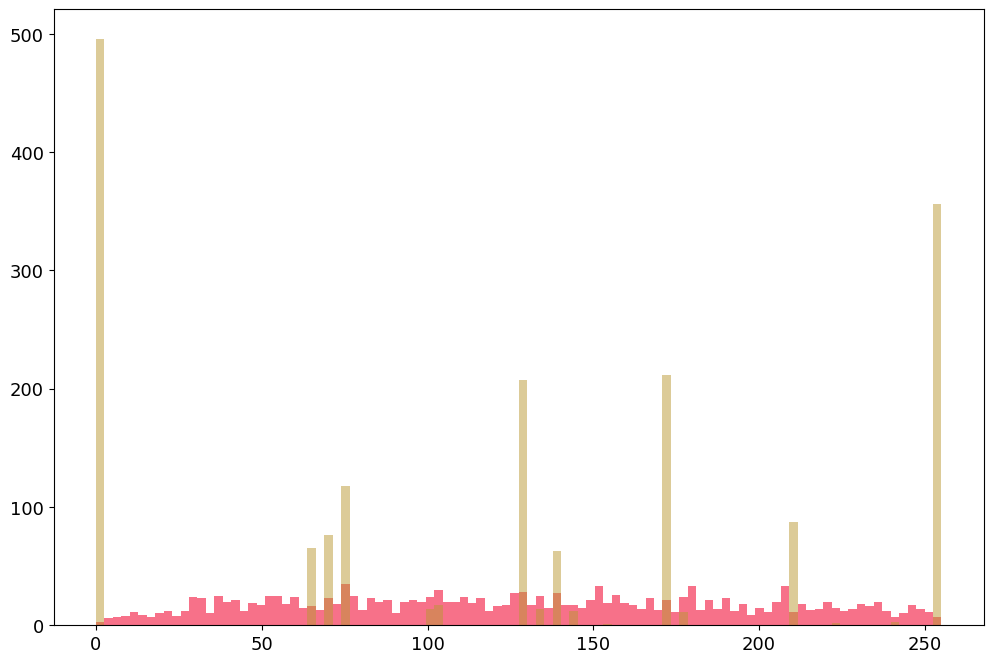

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

channels = ['R', 'G', 'B']
for idx, ch in enumerate(channels):
    ax = axes[idx]
    ax.scatter(df_rgb[f'T_{ch}'], df_rgb[f'P_{ch}'], alpha=0.5, s=8, label=f'{ch}: true vs pred')
    ax.plot([0,255],[0,255],'--',color='black',lw=1)
    ax.set_title(f'{ch}: pred vs true')
    # Show Pearson r in legend or as text
    r_val = df_rgb[[f'T_{ch}',f'P_{ch}']].corr().iloc[0,1]
    ax.text(0.05, 0.92, f"$r$ = {r_val:.3f}", transform=ax.transAxes, fontsize=12)

plt.tight_layout()
plt.show()


plt.hist(df_rgb[f'T_R'], bins=100, label='True')
plt.hist(df_rgb[f'P_R'], bins=100, label='Pred', alpha=0.5)

In [52]:
print(df_rgb[f'P_R'].unique())
print(df_rgb[f'P_G'].unique())
print(df_rgb[f'P_B'].unique())

[  0  64  75 102 128 139 255 211 173 210 224 240 176  76 154 144 135  70
 100 138]
[  0  64 128 192 211  84 175 216 255  69 105  51 165 180 224 215 230 196
 100 205 193 238 206 102 116 130 149  43 108 166]
[  0  64 130  51 128 139 203 211 198 230 255  19 180  46 140 224 222  80
  50  89  91 144 235 204 217 237 226 177 240]


(array([  1.,   0.,   0.,   2.,   1.,   2.,   2.,  15.,   9.,  17.,  11.,
         32.,  24.,  21.,  19.,  17.,  16.,  10.,   6.,   2.]),
 array([  42.  ,   49.45,   56.9 ,   64.35,   71.8 ,   79.25,   86.7 ,
          94.15,  101.6 ,  109.05,  116.5 ,  123.95,  131.4 ,  138.85,
         146.3 ,  153.75,  161.2 ,  168.65,  176.1 ,  183.55,  191.  ]),
 <BarContainer object of 20 artists>)

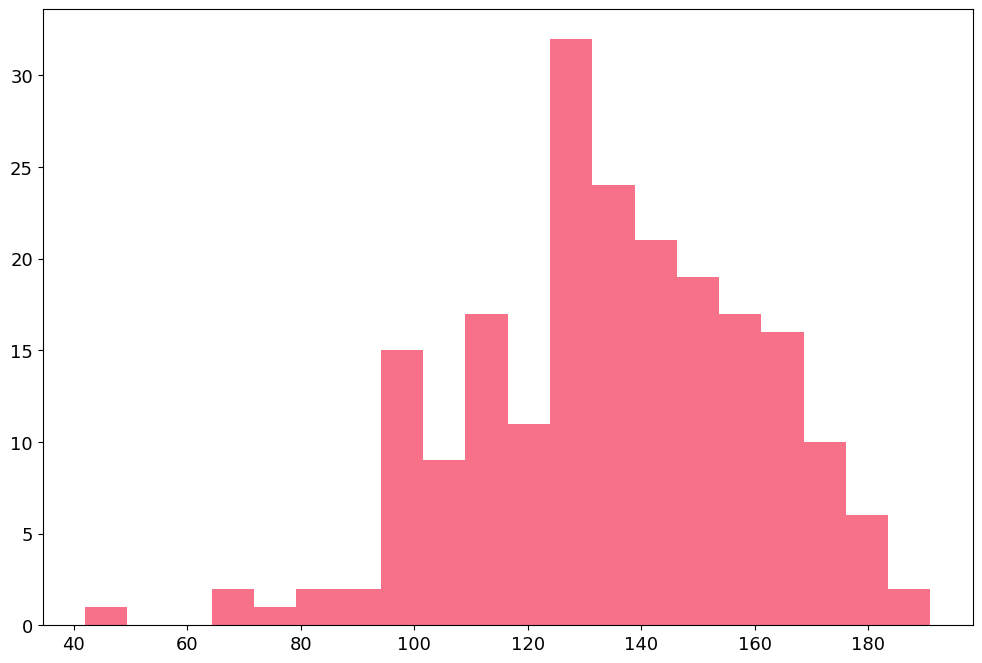

In [64]:
plt.hist(df_rgb[df_rgb['P_R'] == 128]["T_R"], bins=20)

(array([  2.,   1.,   1.,   1.,   4.,   6.,   5.,   8.,   6.,  10.,  10.,
          4.,  10.,   6.,   8.,   5.,   7.,   9.,   7.,   3.]),
 array([  40.  ,   43.75,   47.5 ,   51.25,   55.  ,   58.75,   62.5 ,
          66.25,   70.  ,   73.75,   77.5 ,   81.25,   85.  ,   88.75,
          92.5 ,   96.25,  100.  ,  103.75,  107.5 ,  111.25,  115.  ]),
 <BarContainer object of 20 artists>)

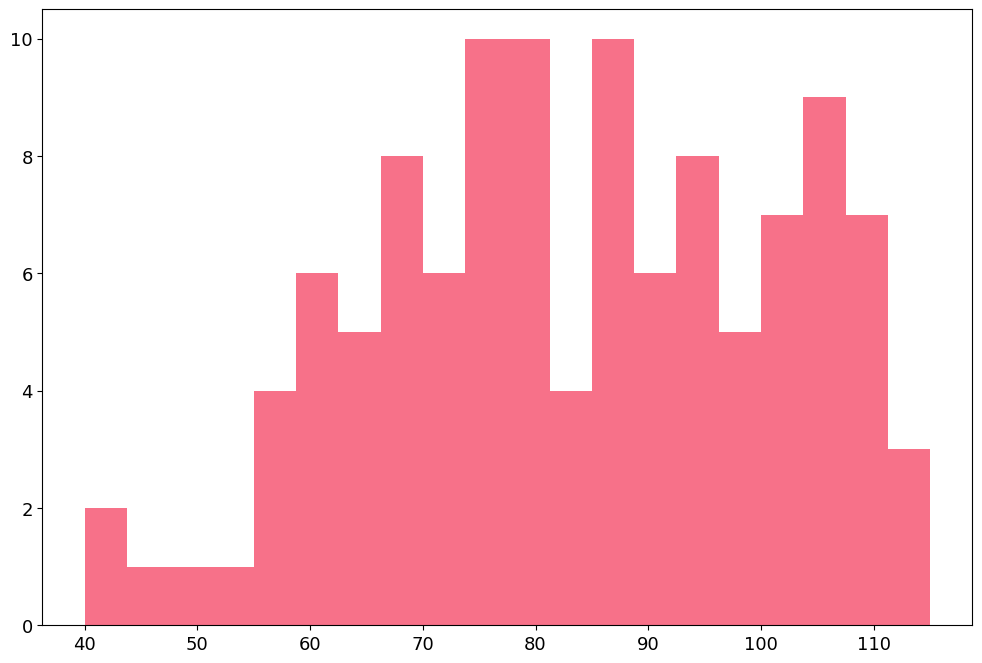

In [59]:
plt.hist(df_rgb[df_rgb['P_R'] == 75]["T_R"], bins=20)

(array([ 3.,  3.,  5.,  4.,  4.,  1.,  3.,  3.,  5.,  4.,  5.,  4.,  0.,
         4.,  2.,  3.,  4.,  1.,  2.,  5.]),
 array([  52.  ,   55.05,   58.1 ,   61.15,   64.2 ,   67.25,   70.3 ,
          73.35,   76.4 ,   79.45,   82.5 ,   85.55,   88.6 ,   91.65,
          94.7 ,   97.75,  100.8 ,  103.85,  106.9 ,  109.95,  113.  ]),
 <BarContainer object of 20 artists>)

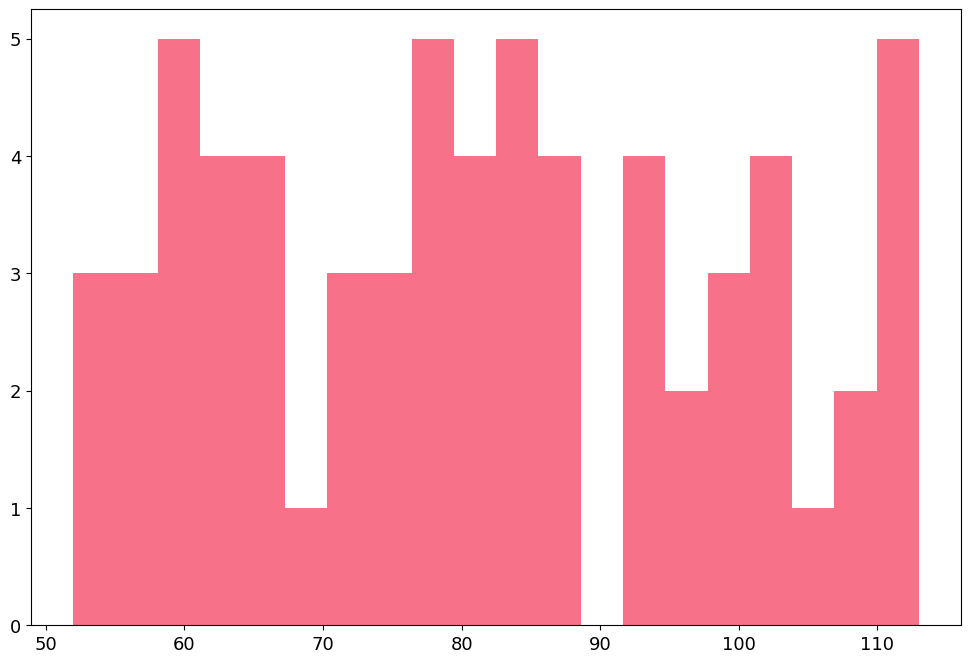

In [ ]:
plt.hist(df_rgb[df_rgb['P_R'] == 64]["T_R"], bins=20)

In [ ]:
plt.hist()

In [73]:
df_rgb[['T_R','P_R']].corr()

,T_R,P_R
T_R,1.000000,0.886255
P_R,0.886255,1.000000


In [74]:
df_rgb[['T_R','P_R']]

,T_R,P_R
0,30,0
1,39,0
2,45,0
3,49,0
4,51,0
...,...,...
1749,249,255
1750,223,255
1751,236,255
1752,249,255
